In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.14.0


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar=True, cache_dir=".",
                                  cache_subdir="")

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

84125825/84125825 [==============================] - 5s 0us/step


In [4]:
os.listdir(dataset_dir)

['README', 'test', 'imdbEr.txt', 'imdb.vocab', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['neg',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_unsup.txt',
 'urls_neg.txt',
 'pos',
 'unsup']

In [6]:
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [12]:
def custom_standarization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", "")
    return tf.strings.regex_replace(stripped_html,
                                    "[%s]" % re.escape(string.punctuation),
                                    "")

In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standarization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length)

In [14]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [15]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  85,   17,  257,    2,  222,    1,  574,   30,  227,   10, 2401,
           1,   52,   23,   25,  426,  248,   12,  306,  279,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [16]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print("313  ---> ", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --->  batman
313  --->  audience
Vocabulary size: 10000


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [21]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 10s 15ms/step - loss: 0.6654 - binary_accuracy: 0.6923 - val_loss: 0.6188 - val_binary_accuracy: 0.7702
Epoch 2/10
625/625 [==============================] - 5s 7ms/step - loss: 0.5534 - binary_accuracy: 0.7984 - val_loss: 0.5037 - val_binary_accuracy: 0.8230
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4504 - binary_accuracy: 0.8425 - val_loss: 0.4255 - val_binary_accuracy: 0.8476
Epoch 4/10
625/625 [==============================] - 9s 14ms/step - loss: 0.3836 - binary_accuracy: 0.8634 - val_loss: 0.3789 - val_binary_accuracy: 0.8592
Epoch 5/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3407 - binary_accuracy: 0.8749 - val_loss: 0.3503 - val_binary_accuracy: 0.8666
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3104 - binary_accuracy: 0.8870 - val_loss: 0.3308 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 7s 12

In [22]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 4ms/step - loss: 0.3152 - binary_accuracy: 0.8702
Loss:  0.31517380475997925
Accuracy:  0.870199978351593


In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

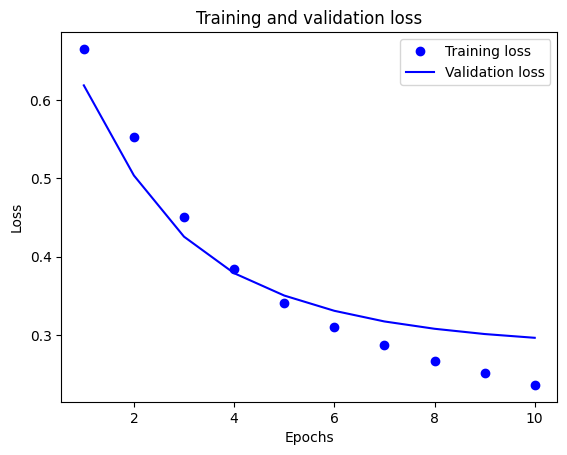

In [25]:
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

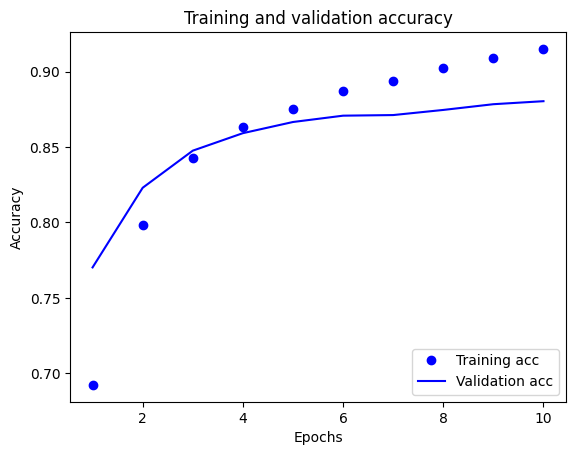

In [26]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()

In [28]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation("sigmoid")
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"]
)

# Test it with "raw_test_ds", which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 6s 7ms/step - loss: 0.3152 - accuracy: 0.8702
0.870199978351593


In [29]:
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 200ms/step


array([[0.61007106],
       [0.43077746],
       [0.35240683]], dtype=float32)

In [30]:
# MIT License
#
# Copyright (c) 2017 François Chollet
# Copyright (c) 2023 KURAMOCHI Kenta
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.